## Point Cloud Registration with Missing Points

AUTHOR : Mike Tyszka  
DATES  : 2018-11-21 JMT From scratch  

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as skt
import skimage.measure as skm

In [98]:
# Generate random points
n_samp = 100
pnts = np.random.randint(-500, 500, size=[n_samp,2])

In [106]:
# Small rigid body transform
T = skt.EuclideanTransform(translation=(-50, 30), rotation=5*np.pi/180)
pnts_tx = T(pnts)

# Remove 25% of points
pnts_tx = pnts_tx[0:int(n_samp*0.75),:]
n_tx = pnts_tx.shape[0]

In [107]:
# Construct distance matrix
dist = np.zeros([n_samp, n_tx])
for rr in range(0, n_samp):
    x, y = pnts[rr,:]
    for cc in range(0, n_tx):
        x_tx, y_tx = pnts_tx[cc,:]
        dx, dy = x_tx - x, y_tx - y
        dist[rr, cc] = np.sqrt(dx**2 + dy**2)

In [108]:
# For each transformed point, find closest original point
# Find minimum distance row in each column
# Construct paired point list for subsequent registration
src = np.zeros([n_tx, 2])
dst = pnts_tx
for cc in range(0, n_tx):
    rmin = np.argmin(dist[:,cc])
    src[cc, :] = pnts[rmin, :]

In [210]:
# Find affine transform mapping dst to src
# RANSAC robust optimization
T_est, inliers = skm.ransac([src, dst],
                            skt.AffineTransform,
                            min_samples=6,
                            residual_threshold=2,
                            max_trials=1000,
                            stop_probability=0.99,
                            stop_sample_num=25)

print('Rotation     : %0.1f deg' % np.rad2deg(T_est.rotation))
print('Translation  : (%0.1f, %0.1f)' % (T_est.translation[0], T_est.translation[1]))
print('Inlier count : %d' %np.sum(inliers))

# Apply the estimated transform to recover original points
pnts_rx = T_est.inverse(pnts_tx)

Rotation     : 5.0 deg
Translation  : (-50.0, 30.0)
Inlier count : 27


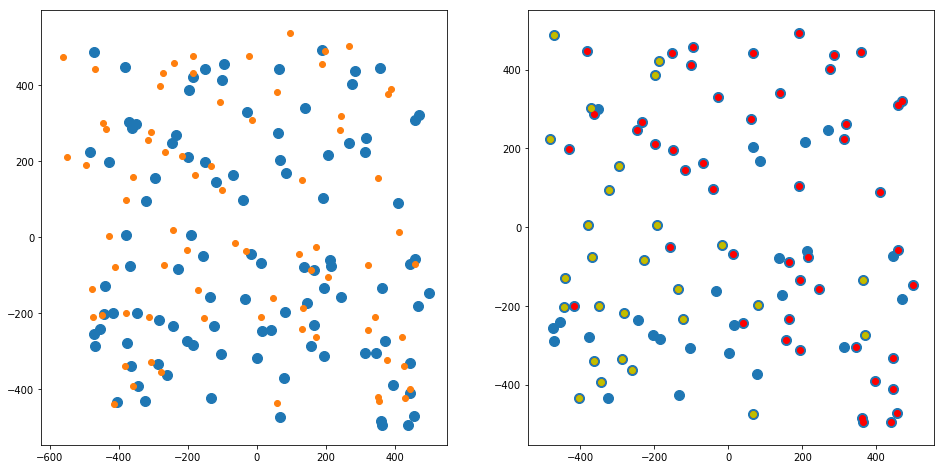

In [211]:
# Scatter plot
fig, ax = plt.subplots(1, 2, figsize=(16,8))

ax[0].scatter(pnts[:,0], pnts[:,1], s=100)
ax[0].scatter(pnts_tx[:,0], pnts_tx[:,1])

ax[1].scatter(pnts[:,0], pnts[:,1], s=100)
ax[1].scatter(pnts_rx[:,0], pnts_rx[:,1], c='r')
ax[1].scatter(pnts_rx[inliers,0], pnts_rx[inliers,1], c='y')

plt.show()